# Interfacing Julia with other languages

### C and Fortran

In [7]:
# Call C and FORTRAL call directly..
t = ccall( (:clock, "libc.so.6"), Int32, ())

12238390

In [5]:
# mylib.h:
#=
#ifndef _MYLIB_H_
#define _MYLIB_H_

extern float iplustwo (float i);
=#

# mylib.c:
#=
float
iplustwo (float i){
 return i+2;
}
=#

# compiled with:
# gcc -o mylib.o -c mylib.c
# gcc -shared -o libmylib.so mylib.o -lm -fPIC

i = 2
const mylib = joinpath(@__DIR__, "libmylib.so")

"/home/lobianco/git/juliatutorial/assets/libmylib.so"

In [6]:
j = ccall((:iplustwo, mylib), Float32, (Float32,), i)

4.0f0

### C++
 - use the [Cxx](https://github.com/Keno/Cxx.jl) package

### Python
 - [PyCall](https://github.com/JuliaPy/PyCall.jl), a "relatively" low level library, allows to call any Python library
 - this in turn has been used to bild wrappers for all the most important Python libraries

In [21]:
# e.g.PyCall is used in the OdsIO package to wrapper the Python ezodf library to import/export
# from/to OpenOffice/LibreOffice spreadsheets:

# Pkg.add("OdsIO") # Do this only once: package manager integrated in the language

using OdsIO
df = ods_read("spreadsheet.ods";sheetName="Sheet2",retType="DataFrame")

,a,b,c
,Int64,Int64,Int64
1,21,22,23
2,31,32,33


In [12]:
# This is the actual code form the Package OdsIO


export ods_readall, ods_read, odsio_test, odsio_autotest
using PyCall
using DataFrames

"""
    ods_readall(filename; <keyword arguments>)
Return a dictionary of tables|dictionaries|dataframes indexed by position or name in the original OpenDocument Spreadsheet (.ods) file.
# Arguments
* `sheetsNames=[]`: the list of sheet names from which to import data.
* `sheetsPos=[]`: the list of sheet positions (starting from 1) from which to import data.
* `ranges=[]`: a list of pair of touples defining the ranges in each sheet from which to import data, in the format ((tlr,tlc),(brr,brc))
* `innerType="Matrix"`: the type of the inner container returned. Either "Matrix", "Dict" or "DataFrame"
# Notes
* sheetsNames and sheetsPos can not be given together
* ranges is defined using integer positions for both rows and columns
* individual dictionaries or dataframes are keyed by the values of the cells in the first row specified in the range, or first row if `range` is not given
* innerType="Matrix", differently from innerType="Dict", preserves original column order, it is faster and require less memory
* using innerType="DataFrame" also preserves original column order and try to auto-convert column types (working for Int64, Float64, String, in that order)
# Examples
```julia
julia> outDic  = ods_readall("spreadsheet.ods";sheetsPos=[1,3],ranges=[((1,1),(3,3)),((2,2),(6,4))], innerType="Dict")
Dict{Any,Any} with 2 entries:
  3 => Dict{Any,Any}(Pair{Any,Any}("c",Any[33.0,43.0,53.0,63.0]),Pair{Any,Any}("b",Any[32.0,42.0,52.0,62.0]),Pair{Any,Any}("d",Any[34.0,44.0,54.…
  1 => Dict{Any,Any}(Pair{Any,Any}("c",Any[23.0,33.0]),Pair{Any,Any}("b",Any[22.0,32.0]),Pair{Any,Any}("a",Any[21.0,31.0]))
```
"""
function ods_readall(filename::AbstractString;sheetsNames::AbstractVector=String[],sheetsPos::AbstractVector=Int64[],ranges::AbstractVector=Tuple{Tuple{Int64,Int64},Tuple{Int64,Int64}}[],innerType::AbstractString="Matrix")

    #try
    #   @pyimport ezodf
    #catch
    #  error("The OdsIO module is correctly installed, but your python installation is missing the 'ezodf' module.")
    #end
    #@pyimport ezodf
    toReturn = Dict() # The outer container is always a dictionary
    try
      global doc = ezodf.opendoc(filename)
    catch
      error("I can not open for reading file $filename at $(pwd())")
    end

    nsheets = length(doc.sheets)
    toReturnKeyType = "name"
    if !isempty(sheetsNames) && !isempty(sheetsPos)
        error("Do not use sheetNames and sheetPos together")
    end
    if !isempty(sheetsPos)
        toReturnKeyType = "pos"
    end
    sheetsCounter=0

    for (is, sheet) in enumerate(doc.sheets)
        if is in sheetsPos || sheet.name in sheetsNames || (isempty(sheetsNames) && isempty(sheetsPos))
            sheetsCounter += 1
            r_min = 1
            r_max = sheet.nrows()
            c_min = 1
            c_max = sheet.ncols()
            try
                if !isempty(ranges) && !isempty(ranges[sheetsCounter])
                    r_min::Int64     = ranges[sheetsCounter][1][1]
                    r_max::Int64     = min(ranges[sheetsCounter][2][1],sheet.nrows())
                    c_min::Int64     = ranges[sheetsCounter][1][2]
                    c_max::Int64     = min(ranges[sheetsCounter][2][2],sheet.ncols())
                else
                    # ezodf module include also empty final rows/cols in nrows()/ncols()
                    # the following code adjust r_max and c_max as to exclude empty final rows/cols if
                    # these have not been manually specified (i.e., no corrections if manually specified)

                    # Checking empty final rows..
                    emptyFinalRows = 0
                    for i = r_max-1:-1:0
                        row = sheet.row(i)
                        allEmpty = true
                        for (j, cell) in enumerate(row)
                            if cell.value != nothing
                                allEmpty = false
                                break
                            end
                        end
                        if(!allEmpty)
                            break
                        else
                            emptyFinalRows += 1
                        end
                    end
                    r_max -= emptyFinalRows
                    # Checking empty final cols..
                    emptyFinalCols = 0
                    for i = c_max-1:-1:0
                        col = sheet.column(i)
                        allEmpty = true
                        for (j, cell) in enumerate(col)
                            if cell.value != nothing
                                allEmpty = false
                                break
                            end
                        end
                        if(!allEmpty)
                            break
                        else
                            emptyFinalCols += 1
                        end
                    end
                    c_max -= emptyFinalCols
                end
            catch
                error("There is a problem with the range. Range should be defined as a list of pair of touples ((tlr,tlc),(brr,brc)) for each sheet to import, using integer positions." )
            end
            if (innerType=="Matrix" || innerType=="Dict" || innerType=="DataFrame" )
                innerMatrix = Array{Any,2}(undef,r_max-r_min+1,c_max-c_min+1)
                r::Int64=1
                for (i::Int64, row) in enumerate(sheet.rows())
                    if (i>=r_min && i <= r_max) # data row
                        c::Int64=1
                        for (j::Int64, cell) in enumerate(row)
                            if (j>=c_min && j<=c_max)
                                # Try saving the value as integer if that's actually possible
                                if typeof(cell.value) <: Number
                                    if isinteger(cell.value)
                                        innerMatrix[[r],[c]] .= convert(Int64,cell.value)
                                    else
                                        innerMatrix[[r],[c]] .= cell.value
                                    end
                                else
                                    innerMatrix[[r],[c]] .= cell.value
                                end
                                c = c+1
                            end
                        end
                        r = r+1
                    end
                end
                if innerType=="Matrix"
                    toReturnKeyType == "name" ? toReturn[sheet.name] = innerMatrix : toReturn[is] = innerMatrix
                elseif innerType == "Dict"
                    toReturnKeyType == "name" ? toReturn[sheet.name] = Dict([(ch,innerMatrix[2:end,cix]) for (cix::Int64,ch) in enumerate(innerMatrix[1,:])]) : toReturn[is] = Dict([(ch,innerMatrix[2:end,cix]) for (cix,ch) in enumerate(innerMatrix[1,:])])
                elseif innerType == "DataFrame"
                    df = toDf!(innerMatrix)
                    toReturnKeyType == "name" ? toReturn[sheet.name] =   df : toReturn[is] = df
                end # innerType is really a df
            else # end innerTpe is a Dict check
                error("Only 'Matrix', 'Dict' or 'DataFrame' are supported as innerType/retType.'")
            end # end innerTpe is a Dict or Matrix check
        end # end check is a sheet to retain
    end # for each sheet
    return toReturn
end # end functionSS

ods_readall

### R
- use [RCall](https://github.com/JuliaInterop/RCall.jl)
- widely used ([most asked julia-lang question in Stack Overflow](http://stackoverflow.com/questions/tagged/julia-lang?sort=votes))
- the other way is also possible (use Julia in R). See the [JuliaCall](https://cran.r-project.org/web/packages/JuliaCall/index.html) R package.

In [15]:
using RCall
x = randn(10)

10-element Array{Float64,1}:
  0.225645133910063   
  0.715608408367434   
  1.0158030914642286  
  0.046508426558602885
 -1.3842807192731392  
  0.9898471614641909  
  1.2645930229178683  
 -0.1971853805486571  
  0.726696607407927   
  1.2017220894055294  

In [16]:
R"t.test($x)"

RObject{VecSxp}

	One Sample t-test

data:  `#JL`$x
t = 1.7861, df = 9, p-value = 0.1077
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.1227528  1.0437444
sample estimates:
mean of x 
0.4604958 



In [20]:
using RCall
using RDatasets
mtcars = dataset("datasets","mtcars")
first(mtcars,6)


,Model,MPG,Cyl,Disp,HP,DRat,WT,QSec,VS
,String,Float64,Int64,Float64,Int64,Float64,Float64,Float64,Int64
1,Mazda RX4,21.0,6,160.0,110,3.9,2.62,16.46,0
2,Mazda RX4 Wag,21.0,6,160.0,110,3.9,2.875,17.02,0
3,Datsun 710,22.8,4,108.0,93,3.85,2.32,18.61,1
4,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1
5,Hornet Sportabout,18.7,8,360.0,175,3.15,3.44,17.02,0
6,Valiant,18.1,6,225.0,105,2.76,3.46,20.22,1


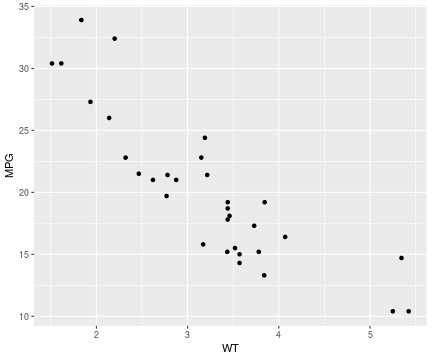

RObject{VecSxp}


In [18]:
R"library(ggplot2)"
R"ggplot($mtcars,aes(x=WT,y=MPG))+geom_point()"
# NB: There exists native plot implementations, some with the same API of ggplot